# Reading shadow_attack's threhold-fpr pairs, and applying it to the test set

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

plt.style.use('seaborn-v0_8-paper')
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)
plt.rc('axes', labelsize=8)

mia_name_mapping = {"losstraj": "losstraj", "shokri": "Class-NN", "yeom": "LOSS", "lira": "LIRA", "aug": "aug", "calibration": "calibrated-loss", "reference": "reference"}
mia_color_mapping = {"losstraj": '#1f77b4', "shokri": '#ff7f0e', "yeom": '#2ca02c', "lira": '#d62728', "aug": '#9467bd', "calibration": '#8c564b', "reference": '#e377c2'}


1. Read the shadow target and regular target

In [2]:
import os
import torch
import numpy as np
import pickle
from typing import List, Tuple, Dict

import sys
sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from miae.eval_methods.experiment import ExperiementSet, TargetDataset

dataset = "cifar10"
model = "resnet56"

shadow_target_dir = "/home/data/wangz56/miae_experiment_aug_more_target_data/shadow_target_model_and_data"
shadow_target_model_dir = shadow_target_dir + f"/{shadow_target_dir}/target_models/{dataset}/{model}/"
shadow_target_data_dir = shadow_target_dir + f"/{dataset}"

target_data_dir = f"/home/data/wangz56/miae_experiment_aug_more_target_data/target/{dataset}"

result_dir = f"/home/data/wangz56/miae_experiment_aug_more_target_data/shadow_attack_threshold_exp/{dataset}/{model}/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)


shadow_target_dataset = TargetDataset.from_dir("shadow target dataset", shadow_target_data_dir)
target_dataset = TargetDataset.from_dir("target dataset", target_data_dir)


ModuleNotFoundError: No module named 'utils'

2. load the shadow attacks predictions and regular attack predictions

In [7]:
# import some helper functions from the ensemble script
from ensemble import obtain_shadow_roc, align_threshold_by_fpr, read_preds
# note that the name 'obtain_shadow_roc' is misleading, it actually computes the ROC for every set of prediction + ground truth data

seeds = [0, 1, 2, 3, 4, 5]
attack_list = ["losstraj", "shokri", "yeom", "aug", "lira", "calibration", "reference"]
pred_path = "/home/data/wangz56/comp_mia_data/miae_experiment_aug_more_target_data"

shadow_target_preds = read_preds(pred_path, "_ensemble_base", seeds, dataset, model, attack_list, shadow_target_dataset.membership)
regular_preds = read_preds(pred_path, "", seeds, dataset, model, attack_list, target_dataset.membership)

3. For each shadow attack, calculate the threshold-fpr pairs

In [8]:
roc_for_each_seed = dict()
aligned_thresholds_for_each_seed = dict()
fprs_to_evaluate = [0.005, 0.01, 0.1]

for sd in seeds:
    roc_for_each_seed[sd] = obtain_shadow_roc(shadow_target_preds[sd], shadow_target_dataset.membership)
    # rocs_for_each_seed is a list of lists, where each inner list contains the ROC AUC for each attack for a single seed
    threshold_fpr_list_single_seed = [tuple([x[0], x[2]]) for x in roc_for_each_seed[sd]]
    aligned_thresholds_for_each_seed[sd] = align_threshold_by_fpr(threshold_fpr_list_single_seed, fprs_to_evaluate)

# report the average and standard deviation of the aligned thresholds at FPR 0.01 for each attack
print("At FPR 0.01:")
for attack_index in range(len(attack_list)):
    thresholds = [aligned_thresholds_for_each_seed[sd][attack_index][0.01] for sd in seeds]
    print(f"Attack: {attack_list[attack_index]} \t \t Average threshold: {np.mean(thresholds)} \t Std: {np.std(thresholds)}")

At FPR 0.01:
Attack: losstraj 	 	 Average threshold: -0.07400278747081757 	 Std: 0.1606443226337433
Attack: shokri 	 	 Average threshold: 0.9999990463256836 	 Std: 1.641744688640756e-06
Attack: yeom 	 	 Average threshold: 1.0 	 Std: 0.0
Attack: aug 	 	 Average threshold: 1.148701786994934 	 Std: 0.4568184018135071
Attack: lira 	 	 Average threshold: 0.2225054457548723 	 Std: 0.007958977760796937
Attack: calibration 	 	 Average threshold: 0.6634571765697413 	 Std: 0.033494877504032926
Attack: reference 	 	 Average threshold: -0.24968243899207465 	 Std: 0.0033669808388647536


4. Apply the threshold to the regular attack predictions, and record the fpr

At FPR 5.00e-03:
	Attack: losstraj 	 	 Average FPR: 1.42e-01 	 Std: 5.75e-02 	 Average TPR: 2.77e-01
	Attack: shokri 	 	 Average FPR: 0.00e+00 	 Std: 0.00e+00 	 Average TPR: 0.00e+00
	Attack: yeom 	 	 Average FPR: 0.00e+00 	 Std: 0.00e+00 	 Average TPR: 0.00e+00
	Attack: aug 	 	 Average FPR: 0.00e+00 	 Std: 0.00e+00 	 Average TPR: 0.00e+00
	Attack: lira 	 	 Average FPR: 2.17e-03 	 Std: 3.71e-04 	 Average TPR: 5.19e-03
	Attack: calibration 	 	 Average FPR: 2.99e-03 	 Std: 2.12e-03 	 Average TPR: 8.58e-03
	Attack: reference 	 	 Average FPR: 1.69e-03 	 Std: 3.21e-04 	 Average TPR: 1.22e-02
At FPR 1.00e-02:
	Attack: losstraj 	 	 Average FPR: 1.43e-01 	 Std: 5.76e-02 	 Average TPR: 2.78e-01
	Attack: shokri 	 	 Average FPR: 2.79e-02 	 Std: 1.76e-02 	 Average TPR: 3.02e-02
	Attack: yeom 	 	 Average FPR: 0.00e+00 	 Std: 0.00e+00 	 Average TPR: 0.00e+00
	Attack: aug 	 	 Average FPR: 0.00e+00 	 Std: 0.00e+00 	 Average TPR: 0.00e+00
	Attack: lira 	 	 Average FPR: 4.82e-03 	 Std: 5.00e-04 	 Averag

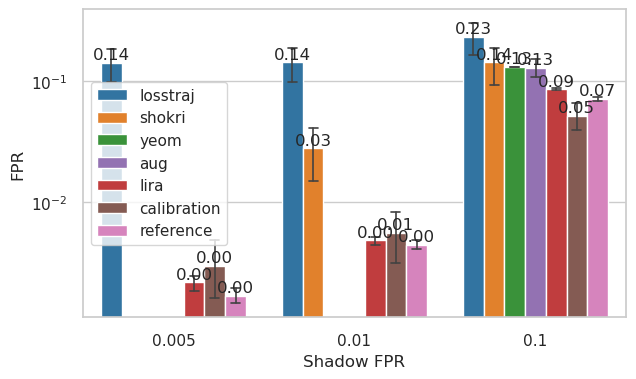

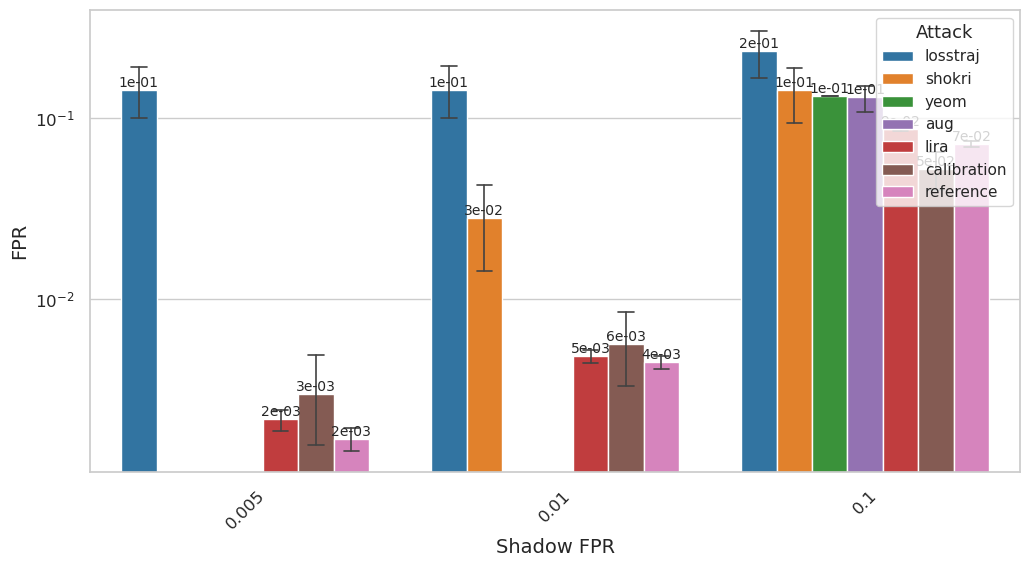

In [9]:
import csv
from copy import deepcopy
import seaborn as sns
import pandas as pd


# {attack: {fpr: {pred_sd_0, ... , pred_sd_n}}}
inner_dict = (dict(zip(fprs_to_evaluate, [list() for i in range(len(fprs_to_evaluate))])))
attack_pred_with_shadow_thres = dict(zip(attack_list, [deepcopy(inner_dict) for i in range(len(attack_list))]))

def batch_calcuate_fpr(attack_pred, save_path, gt):
    """
    A helper function to calculate the FPR for the predictions above, meaning that it's not intended
    to used anywhere else. It also save the result to multiple csv files, each corresponding to a different fpr.

    :param attack_pred: follows the format {attack: {fpr: {pred_sd_0, ... , pred_sd_n}}}
    :param save_path: the path to save the result
    :param gt: the ground truth for the attack
    """

    def calculate_fpr(pred, gt):
        """
        A helper function to calculate the FPR for the given predictions and ground truth.

        :param pred: the predictions
        :param gt: the ground truth
        """
        FP = np.sum(np.logical_and(pred == 1, gt == 0))
        TN = np.sum(np.logical_and(pred == 0, gt == 0))
        return FP / (FP + TN)
    
    def calculate_tpr(pred, gt):
        """
        A helper function to calculate the TPR for the given predictions and ground truth.

        :param pred: the predictions
        :param gt: the ground truth
        """
        TP = np.sum(np.logical_and(pred == 1, gt == 1))
        FN = np.sum(np.logical_and(pred == 0, gt == 1))
        return TP / (TP + FN)

    attack_fpr_after_shadow_thres = deepcopy(attack_pred)
    attack_tpr_after_shadow_thres = deepcopy(attack_pred)
    for attack in attack_pred:
        for fpr in attack_pred[attack]:
            for sd in range(len(seeds)):
                attack_fpr_after_shadow_thres[attack][fpr][sd] = calculate_fpr(attack_pred[attack][fpr][sd], gt)
                attack_tpr_after_shadow_thres[attack][fpr][sd] = calculate_tpr(attack_pred[attack][fpr][sd], gt)
    
    for fpr in attack_pred[attack]:
        with open(os.path.join(save_path, f"attack_pred_fpr_with_shadow_fpr_{fpr}.csv"), "w") as f:
            writer = csv.writer(f)
            writer.writerow(["Attack"] + [f"Seed_{i}" for i in seeds] + ["Average", "Std"])
            print(f"At FPR {fpr:.2e}:")
            # record the average and standard deviation of the FPR for each attack at the given FPR
            for attack in attack_pred:
                fprs = [attack_fpr_after_shadow_thres[attack][fpr][sd] for sd in range(len(seeds))]
                avg, std = np.mean(fprs), np.std(fprs)
                tpr_avg = np.mean([attack_tpr_after_shadow_thres[attack][fpr][sd] for sd in range(len(seeds))])
                print(f"\tAttack: {attack} \t \t Average FPR: {avg:.2e} \t Std: {std:.2e} \t Average TPR: {tpr_avg:.2e}")
                writer.writerow([attack] + fprs + [avg, std])

    return attack_fpr_after_shadow_thres, attack_tpr_after_shadow_thres
                


for sd in seeds: # For each seed, we use the aligned thresholds to re-evaluate the fpr
    for attack_idx in range(len(attack_list)):
        attack_intersection_pred = regular_preds[sd][attack_idx]
        for fpr in fprs_to_evaluate:
            shadow_thres_avg = np.mean([aligned_thresholds_for_each_seed[i][attack_idx][fpr] for i in seeds])
            hard_label_pred = attack_intersection_pred.predictions_to_labels(threshold=shadow_thres_avg, normalization=False)
            attack_pred_with_shadow_thres[attack_list[attack_idx]][fpr].append(hard_label_pred)

fpr_result_dir = result_dir + "apply_shadow_threshold/"
if not os.path.exists(fpr_result_dir):
    os.makedirs(fpr_result_dir)
attack_fpr_with_shadow_thres, attack_tpr_with_shadow_thres = batch_calcuate_fpr(attack_pred_with_shadow_thres, fpr_result_dir, target_dataset.membership)


def bar_chart_visulization(attack_fpr_each_attack: Dict[str, Dict[str, List]], color_mapping: Dict[str, str]):
    """
    Plot the bar chart for the FPR of each attack using the shadow threshold at the shaodw_fpr. Using sns barplot.
    

    :param attack_fpr_each_attack: {attack: {fpr: {pred_sd_0, ... , pred_sd_n}}} the FPRs for each attack with 
    shadow threshold at shadow_fpr, it's a list of FPR for each seed.
    :param color_mapping: the color mapping for each attack
    """
    flatten_data = []
    for attack in attack_fpr_each_attack:
        for fpr in attack_fpr_each_attack[attack]:
            for seed in range(len(seeds)):
                flatten_data.append({'attack': attack, 'shadow_fpr': fpr, 'attack_target_fpr': attack_fpr_each_attack[attack][fpr][seed]})

    df = pd.DataFrame(flatten_data)
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(TEXTWIDTH_INCH, 4))
    ax = sns.barplot(x='shadow_fpr', y='attack_target_fpr', hue='attack', data=df, palette=color_mapping, capsize=.05, errwidth=1.2)
    ax.set_ylabel("FPR")
    ax.set_xlabel("Shadow FPR")
    ax.set_yscale('log')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')
    # rotate bar labels
    plt.legend()


def bar_chart_visualization1(attack_fpr_each_attack: Dict[str, Dict[str, List]], color_mapping: Dict[str, str]):
    """
    Plot the bar chart for the FPR of each attack using the shadow threshold at the shadow_fpr. Using sns barplot.
    
    :param attack_fpr_each_attack: {attack: {fpr: {pred_sd_0, ... , pred_sd_n}}} the FPRs for each attack with 
    shadow threshold at shadow_fpr, it's a list of FPR for each seed.
    :param color_mapping: the color mapping for each attack
    """
    flatten_data = []
    for attack in attack_fpr_each_attack:
        for fpr in attack_fpr_each_attack[attack]:
            for seed in range(len(seeds)):
                flatten_data.append({'attack': attack, 'shadow_fpr': fpr, 'attack_target_fpr': attack_fpr_each_attack[attack][fpr][seed]})

    df = pd.DataFrame(flatten_data)
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 6))  # Increase figure size

    ax = sns.barplot(x='shadow_fpr', y='attack_target_fpr', hue='attack', data=df, palette=color_mapping, capsize=.05, errwidth=1.2)
    ax.set_ylabel("FPR", fontsize=14)  # Increase font size
    ax.set_xlabel("Shadow FPR", fontsize=14)  # Increase font size
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.xticks(rotation=45)  # Rotate x-axis labels
    ax.legend(title='Attack', title_fontsize='13', fontsize='11', loc='upper right')  # Customize legend

    # Adding bar labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.e', label_type='edge', fontsize=10)

    
    plt.show()


bar_chart_visulization(attack_fpr_with_shadow_thres, mia_color_mapping)
bar_chart_visualization1(attack_fpr_with_shadow_thres, mia_color_mapping)



5. Check the True Positive samples

In [10]:
def batch_calculate_tp_samples(attack_pred, save_path, gt):
    """
    Calculate the true positives sample ids for the given predictions.
    """

    def calculate_tp_samples(pred, gt):
        """
        Calculate the true positive samples for the given predictions.
        """
        TP = np.logical_and(pred == 1, gt == 1)
        return np.where(TP)[0]

    attack_tp_samples = deepcopy(attack_pred)
    for attack in attack_pred:
        for fpr in attack_pred[attack]:
            for sd in range(len(seeds)):
                attack_tp_samples[attack][fpr][sd] = calculate_tp_samples(attack_pred[attack][fpr][sd], gt)
    
    for fpr in attack_pred[attack]:
        with open(os.path.join(save_path, f"attack_tp_samples_fpr_{fpr}.csv"), "w") as f:
            writer = csv.writer(f)
            writer.writerow(["Attack"] + [f"Seed_{i}" for i in seeds])
            for attack in attack_pred:
                writer.writerow([attack] + attack_tp_samples[attack][fpr])

    return attack_tp_samples

def intersection_process(pred_for_multiple_seed, gt):
    """
    Calculate the intersection of the predictions for multiple seeds.
    """
    intersection = np.zeros(len(gt))
    for pred in pred_for_multiple_seed:
        intersection += pred
    return np.where(intersection == len(pred_for_multiple_seed))[0]

attack_tp_samples = batch_calculate_tp_samples(attack_pred_with_shadow_thres, fpr_result_dir, target_dataset.membership)
# report the number of tp samples at each FPR
print("At FPR 0.01, number of tp samples on avg:")
for attack in attack_tp_samples:
    for fpr in attack_tp_samples[attack]:
        avg_tp_samples = np.mean([len(attack_tp_samples[attack][fpr][sd]) for sd in range(len(seeds))])
        print(f"Attack: {attack} \t actual FPR: {attack_fpr_with_shadow_thres[attack][fpr][0]:.2e} \t Average TP samples: {avg_tp_samples:.1f}")
intersection_prediction_index = deepcopy(attack_tp_samples)


print("At FPR 0.01, number of intersection member samples:")
for attack in attack_fpr_with_shadow_thres:
    for fpr in attack_fpr_with_shadow_thres[attack]:
        intersection_prediction_index[attack][fpr] = intersection_process(attack_pred_with_shadow_thres[attack][fpr], target_dataset.membership)
        print(f"Attack: {attack} \t actual FPR: {attack_fpr_with_shadow_thres[attack][fpr][0]:.2e} \t Intersection TP samples: {len(intersection_prediction_index[attack][fpr])}")


At FPR 0.01, number of tp samples on avg:
Attack: losstraj 	 actual FPR: 1.08e-01 	 Average TP samples: 4150.7
Attack: losstraj 	 actual FPR: 1.09e-01 	 Average TP samples: 4167.3
Attack: losstraj 	 actual FPR: 1.63e-01 	 Average TP samples: 5781.0
Attack: shokri 	 actual FPR: 0.00e+00 	 Average TP samples: 0.0
Attack: shokri 	 actual FPR: 2.45e-02 	 Average TP samples: 452.8
Attack: shokri 	 actual FPR: 1.38e-01 	 Average TP samples: 2449.5
Attack: yeom 	 actual FPR: 0.00e+00 	 Average TP samples: 0.0
Attack: yeom 	 actual FPR: 0.00e+00 	 Average TP samples: 0.0
Attack: yeom 	 actual FPR: 1.31e-01 	 Average TP samples: 2055.0
Attack: aug 	 actual FPR: 0.00e+00 	 Average TP samples: 0.0
Attack: aug 	 actual FPR: 0.00e+00 	 Average TP samples: 0.0
Attack: aug 	 actual FPR: 1.11e-01 	 Average TP samples: 2679.0
Attack: lira 	 actual FPR: 2.40e-03 	 Average TP samples: 77.8
Attack: lira 	 actual FPR: 5.13e-03 	 Average TP samples: 138.7
Attack: lira 	 actual FPR: 8.73e-02 	 Average TP sam

In [11]:
# calculate percision
def calculate_precision(pred, gt):
    """
    Calculate the precision for the given predictions.
    """
    TP = np.sum(np.logical_and(pred == 1, gt == 1))
    FP = np.sum(np.logical_and(pred == 1, gt == 0))
    return TP / (TP + FP)

def batch_calculate_precision(attack_pred, gt):
    """
    Calculate the precision for the given predictions.
    """
    attack_precision = deepcopy(attack_pred)
    for attack in attack_pred:
        for fpr in attack_pred[attack]:
            for sd in range(len(seeds)):
                attack_precision[attack][fpr][sd] = calculate_precision(attack_pred[attack][fpr][sd], gt)
    return attack_precision

attack_precision = batch_calculate_precision(attack_pred_with_shadow_thres, target_dataset.membership)
# report the precision at each FPR
print("At FPR 0.01, precision on avg:")
for attack in attack_precision:
    for fpr in attack_precision[attack]:
        avg_precision = np.mean([attack_precision[attack][fpr][sd] for sd in range(len(seeds))])
        print(f"Attack: {attack} \t actual FPR: {attack_fpr_with_shadow_thres[attack][fpr][0]:.2e} \t Average precision: {avg_precision:.2f}")

# precision for intersection samples
print()
print("At FPR 0.01, intersection precision:")
for attack in attack_precision:
    for fpr in attack_precision[attack]:
        intersection_pred = np.zeros(len(target_dataset.membership))
        intersection_precision = np.zeros(len(target_dataset.membership))
        intersection_precision[intersection_prediction_index[attack][fpr]] = 1
        intersection_precision = calculate_precision(intersection_precision, target_dataset.membership)
        print(f"Attack: {attack} \t actual FPR: {attack_fpr_with_shadow_thres[attack][fpr][0]:.2e} \t Intersection precision: {intersection_precision:.2f}")

At FPR 0.01, precision on avg:
Attack: losstraj 	 actual FPR: 1.08e-01 	 Average precision: 0.67
Attack: losstraj 	 actual FPR: 1.09e-01 	 Average precision: 0.67
Attack: losstraj 	 actual FPR: 1.63e-01 	 Average precision: 0.63
Attack: shokri 	 actual FPR: 0.00e+00 	 Average precision: nan
Attack: shokri 	 actual FPR: 2.45e-02 	 Average precision: 0.53
Attack: shokri 	 actual FPR: 1.38e-01 	 Average precision: 0.53
Attack: yeom 	 actual FPR: 0.00e+00 	 Average precision: nan
Attack: yeom 	 actual FPR: 0.00e+00 	 Average precision: nan
Attack: yeom 	 actual FPR: 1.31e-01 	 Average precision: 0.51
Attack: aug 	 actual FPR: 0.00e+00 	 Average precision: nan
Attack: aug 	 actual FPR: 0.00e+00 	 Average precision: nan
Attack: aug 	 actual FPR: 1.11e-01 	 Average precision: 0.58
Attack: lira 	 actual FPR: 2.40e-03 	 Average precision: 0.71
Attack: lira 	 actual FPR: 5.13e-03 	 Average precision: 0.66
Attack: lira 	 actual FPR: 8.73e-02 	 Average precision: 0.54
Attack: calibration 	 actual 

/tmp/ipykernel_2402973/1079355742.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return TP / (TP + FP)


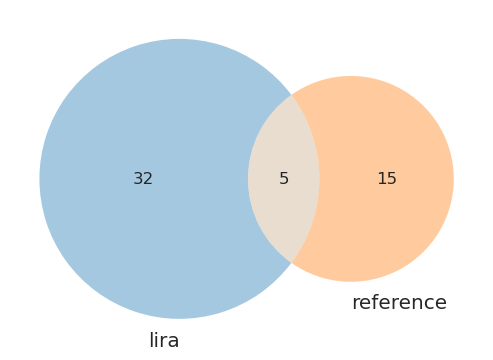

Pair wise ensemble via max precision: 0.94


In [12]:
"""
At a low shadow FPR (ie: 0.01), we apply the shadow thresholds to attacks and some attack are able to capture 
some true positive at a low FPR, and with high precision. We want to see if they are non-overlapping with Venn diagram.

We are picking shadow FPR 0.01, and pair of attacks: {lira, reference}
"""

shadow_fpr_to_plot_venn = 0.01

from matplotlib_venn import venn2, venn3

def venn_diagram(attack_tp_samples: Dict[str, List], attack_list, attack_colors, save_path):
    """
    Given TP samples (as index) from 2 attacks, plot the Venn diagram for the TP samples.
    """
    tp_samples = [set(attack_tp_samples[attack]) for attack in attack_list]
    venn2(subsets=(tp_samples[0], tp_samples[1]), set_labels=attack_list, set_colors=attack_colors)
    plt.show()

attack_list_to_plot_venn = ["lira", "reference"]
attack_colors = [mia_color_mapping[attack] for attack in attack_list]
attack_tp_samples_to_plot_venn = dict()
for attack in attack_list_to_plot_venn:
    attack_tp_samples_to_plot_venn[attack] = intersection_prediction_index[attack][shadow_fpr_to_plot_venn]

venn_diagram(attack_tp_samples_to_plot_venn, attack_list_to_plot_venn, attack_colors, result_dir)

pair_wise_ensemble_via_max = np.zeros(len(target_dataset.membership))
for attack in attack_list_to_plot_venn:
    pair_wise_ensemble_via_max[intersection_prediction_index[attack][shadow_fpr_to_plot_venn]] = 1

pair_wise_ensemble_via_max_precision = calculate_precision(pair_wise_ensemble_via_max, target_dataset.membership)
print(f"Pair wise ensemble via max precision: {pair_wise_ensemble_via_max_precision:.2f}")
